<a href="https://colab.research.google.com/github/i-SanMartin/FastAI/blob/main/06_Multicat/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 26.5 MB/s 
     |████████████████████████████████| 46 kB 4.6 MB/s 
     |████████████████████████████████| 188 kB 56.3 MB/s 
     |████████████████████████████████| 1.2 MB 46.6 MB/s 
     |████████████████████████████████| 53 kB 2.3 MB/s 
     |████████████████████████████████| 51 kB 316 kB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *

##Data

In [3]:
#Download the data
path = untar_data(URLs.BIWI_HEAD_POSE)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
#See the content of the data
path.ls().sorted()

(#50) [Path('01'),Path('01.obj'),Path('02'),Path('02.obj'),Path('03'),Path('03.obj'),Path('04'),Path('04.obj'),Path('05'),Path('05.obj')...]

In [6]:
(path/'01').ls().sorted()

(#1000) [Path('01/depth.cal'),Path('01/frame_00003_pose.txt'),Path('01/frame_00003_rgb.jpg'),Path('01/frame_00004_pose.txt'),Path('01/frame_00004_rgb.jpg'),Path('01/frame_00005_pose.txt'),Path('01/frame_00005_rgb.jpg'),Path('01/frame_00006_pose.txt'),Path('01/frame_00006_rgb.jpg'),Path('01/frame_00007_pose.txt')...]

In [7]:
#We have a jpg and a pose txt document for each image
#With this function we obtain the path of a pose doc of a given jpg
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('12/frame_00475_pose.txt')

In [8]:
#Shape of an image
im = PILImage.create(img_files[0])
im.shape

(480, 640)

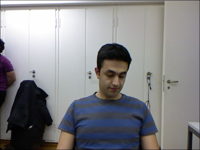

In [9]:
im.to_thumb(200)

In [10]:
#Function to obtain the center of the face in the Biwi dataset
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])

In [11]:
get_ctr(img_files[0])

tensor([371.2351, 242.5490])

In [12]:
biwi = DataBlock(
    blocks=(ImageBlock, PointBlock),
    get_items=get_image_files,
    get_y=get_ctr,
    splitter=FuncSplitter(lambda o: o.parent.name=='13'),
    batch_tfms=[*aug_transforms(size=(240,320)), 
                Normalize.from_stats(*imagenet_stats)]
)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


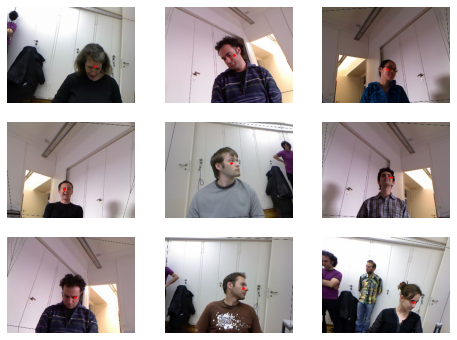

In [13]:
#Independant variables
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [14]:
#Shape of a batch
xb,yb = dls.one_batch()
xb.shape,yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

In [93]:
#The 3 is because it contains 3 images of 240x320 for each color
#We will convert it in a tensor with trhee colors for each of 240x320 pixels
image = xb[0].T
image = image.permute(1,0,2)
image.shape

torch.Size([240, 320, 3])

In [86]:
xb.max(),xb.min()

(TensorImage(2.6400, device='cuda:0'), TensorImage(-2.1179, device='cuda:0'))

In [94]:
#Valid range for imshow with RGB data is [0..1] for floats and we have [2.64, -2.64](estimated) so:
image = image + 2.64
image = image / (2.64 * 2)

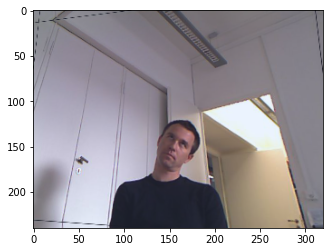

In [95]:
plt.imshow(image.cpu())

In [96]:
#Dependat variable
yb[0]

TensorPoint([[0.0246, 0.2053]], device='cuda:0')

##Model

In [97]:
#The coordinates in fastai and pytorch are rescalated between -1 and 1,
#so we have to specify the range of the output in y_range
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [98]:
#Fastai implements y_range as:
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

In [99]:
#If we dont specify a loss function fastai chooses one as default
dls.loss_func

FlattenedLoss of MSELoss()

In [100]:
#It makes sense that the loss function is MSELoss since we are trying to predict something as close as possible
#You can passa an other loss function by changing the loss_func parameter

SuggestedLRs(valley=0.0020892962347716093)

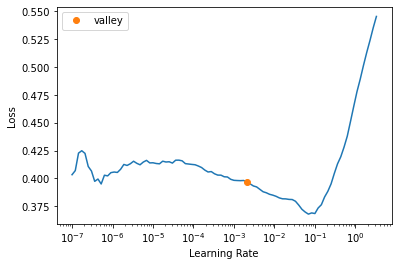

In [101]:
#Pick a good learning rate
learn.lr_find()

In [102]:
lr = 1e-2
learn.fine_tune(3, lr)

epoch,train_loss,valid_loss,time
0,0.047986,0.010720,02:23


epoch,train_loss,valid_loss,time
0,0.007620,0.001909,02:32
1,0.003018,0.001130,02:33
2,0.001450,0.000287,02:34


In [106]:
#The loss will be around 0.0001 which correspond to a error in the cordinate prediction of:
math.sqrt(0.0001)

0.01

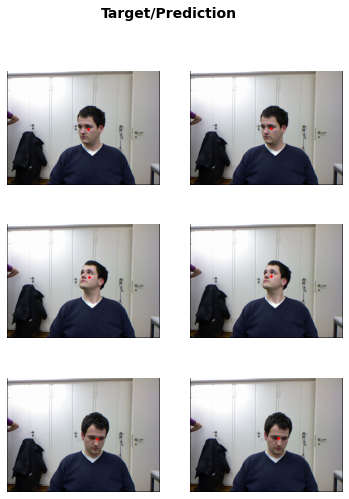

In [107]:
#Let's see the results
learn.show_results(ds_idx=1, nrows=3, figsize=(6,8))